In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
import numpy as np
from seaborn import *
from sklearn import *
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import *
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
from sklearn.metrics import  mean_absolute_error

pd.set_option('display.max_columns', None)

Create DataFrame, Handling Null Values, Filtering Year

In [37]:
# Load CSV files
races_df = pd.read_csv('races.csv')[['raceId', 'year', 'round', 'circuitId', 'name', 'date']]
lap_times_df = pd.read_csv('lap_times.csv')[['raceId', 'driverId', 'lap', 'milliseconds']]
results_df = pd.read_csv('results.csv')[['raceId', 'driverId', 'grid', 'position','positionOrder', 'points', 'laps', 'milliseconds', 'rank']]
drivers_df = pd.read_csv('drivers.csv')[['driverId', 'driverRef']]
pit_stops_df = pd.read_csv('pit_stops.csv')[['raceId', 'driverId', 'lap', 'milliseconds']]

# Merge the DataFrames
merged_df = pd.merge(races_df, lap_times_df, on='raceId')
merged_df = pd.merge(merged_df, results_df, on=['raceId', 'driverId'])
merged_df = pd.merge(merged_df, drivers_df, on='driverId')

# Merge pit_stops_df based on raceId, driverId, and lap
merged_df = pd.merge(merged_df, pit_stops_df, on=['raceId', 'driverId', 'lap'], how='left')

# Replace NaN values with 0
merged_df.fillna(0, inplace=True)

# Rename columns
merged_df.rename(columns={'grid':'starting_pos','positionOrder':'resulted_pos','name': 'race_name','milliseconds_x': 'lap_time_ms', 'laps': 'race_laps','milliseconds_y': 'race_time_ms', 'milliseconds': 'pitstop_ms'}, inplace=True)

# Filter data for the years 2011 to 2023
merged_df = merged_df[(merged_df['year'] >= 2017) & (merged_df['year'] <= 2023)]

# Delete Duplicates
merged_df = merged_df.drop_duplicates()

# Display the resulting DataFrame
merged_df.head()


raceId  year  round  circuitId              race_name        date  \
10506     969  2017      1          1  Australian Grand Prix  2017-03-26   
10507     969  2017      1          1  Australian Grand Prix  2017-03-26   
10508     969  2017      1          1  Australian Grand Prix  2017-03-26   
10509     969  2017      1          1  Australian Grand Prix  2017-03-26   
10510     969  2017      1          1  Australian Grand Prix  2017-03-26   

       driverId  lap  lap_time_ms  starting_pos position  resulted_pos  \
10506         1    1        94404             1        2             2   
10507         1    2        89638             1        2             2   
10508         1    3        89119             1        2             2   
10509         1    4        89044             1        2             2   
10510         1    5        88786             1        2             2   

       points  race_laps race_time_ms rank driverRef  pitstop_ms  
10506    18.0         57      5061647    6  hamilton         0.0  
10507    18.0         57      5061647    6  hamilton         0.0  
10508    18.0         57      5061647    6  hamilton         0.0  
10509    18.0         57      5061647    6  hamilton         0.0  
10510    18.0         57      5061647    6  hamilton         0.0

Show Rows Where Races Had Pitstops

In [38]:
# Filter rows where pitstops are not equal to 0
filtered_df = merged_df[merged_df['pitstop_ms'] != 0]
# Display the resulting DataFrame
filtered_df.head()

raceId  year  round  circuitId              race_name        date  \
10522     969  2017      1          1  Australian Grand Prix  2017-03-26   
10566     970  2017      2         17     Chinese Grand Prix  2017-04-09   
10567     970  2017      2         17     Chinese Grand Prix  2017-04-09   
10568     970  2017      2         17     Chinese Grand Prix  2017-04-09   
10598     970  2017      2         17     Chinese Grand Prix  2017-04-09   

       driverId  lap  lap_time_ms  starting_pos position  resulted_pos  \
10522         1   17       106345             1        2             2   
10566         1    4       130924             1        1             1   
10567         1    5       180642             1        1             1   
10568         1    6       167366             1        1             1   
10598         1   36       101641             1        1             1   

       points  race_laps race_time_ms rank driverRef  pitstop_ms  
10522    18.0         57      5061647    6  hamilton     21709.0  
10566    25.0         56      5856158    1  hamilton     22999.0  
10567    25.0         56      5856158    1  hamilton     17616.0  
10568    25.0         56      5856158    1  hamilton     17737.0  
10598    25.0         56      5856158    1  hamilton     22668.0

Show 2023 Highest Scoring Drivers

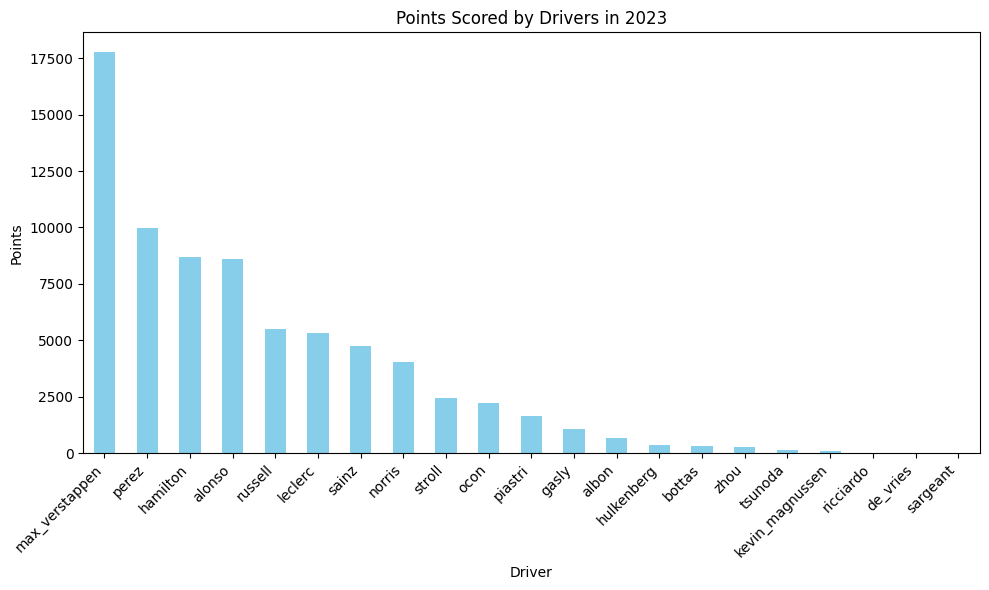

In [39]:
# Filter data for the year 2023
merged_df_2023 = merged_df[merged_df['year'] == 2023]

# Group by driverRef and sum the points
points_by_driver = merged_df_2023.groupby('driverRef')['points'].sum().sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=(10, 6))
points_by_driver.plot(kind='bar', color='skyblue')
plt.title('Points Scored by Drivers in 2023')
plt.xlabel('Driver')
plt.ylabel('Points')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




Show 2023 Most Pitstop Times MS

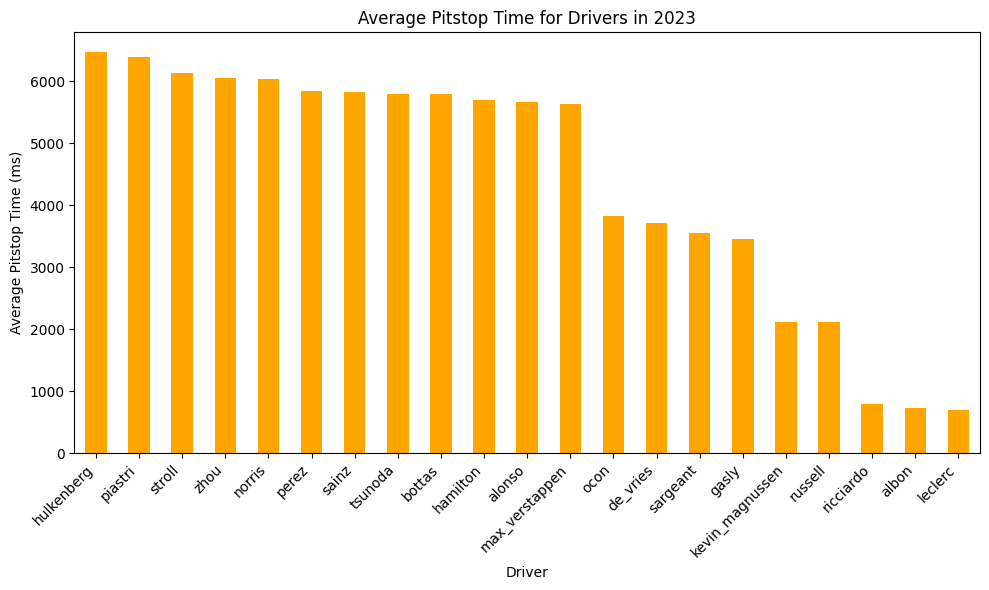

In [40]:
# Filter data for the year 2023
merged_df_2023 = merged_df[merged_df['year'] == 2023]

# Group by driverRef and calculate the average pitstop time (in milliseconds)
pitstop_time_by_driver = merged_df_2023.groupby('driverRef')['pitstop_ms'].mean().sort_values(ascending=False)

# Plot the bar graph
plt.figure(figsize=(10, 6))
pitstop_time_by_driver.plot(kind='bar', color='orange')
plt.title('Average Pitstop Time for Drivers in 2023')
plt.xlabel('Driver')
plt.ylabel('Average Pitstop Time (ms)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


HeatMap

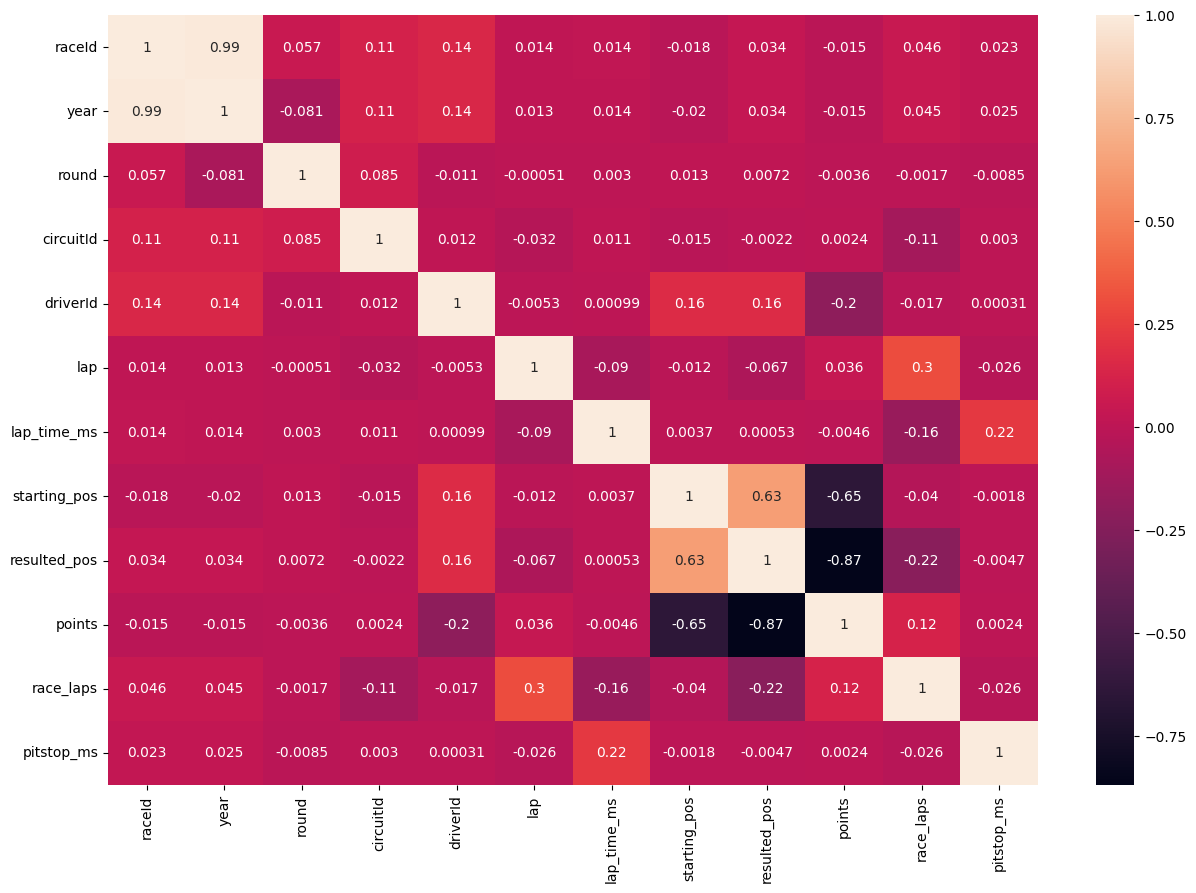

In [41]:
# Make list for numerical columns
numeric_columns = merged_df.select_dtypes(include=['float64', 'int64'])

# Plot HeatMap
plt.figure(figsize=(15, 10))
sns.heatmap(numeric_columns.corr(), annot=True)
plt.show()



Kernal Density Estimation

C:\Users\USER\AppData\Local\Temp\ipykernel_14528\227219156.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df[column], shade=True, color='darkblue')
C:\Users\USER\AppData\Local\Temp\ipykernel_14528\227219156.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df[column], shade=True, color='darkblue')
C:\Users\USER\AppData\Local\Temp\ipykernel_14528\227219156.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(merged_df[column], shade=True, color='darkblue')
C:\Users\USER\AppData\Local\Temp\ipykernel_14528\227219156.py:15: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=Tr

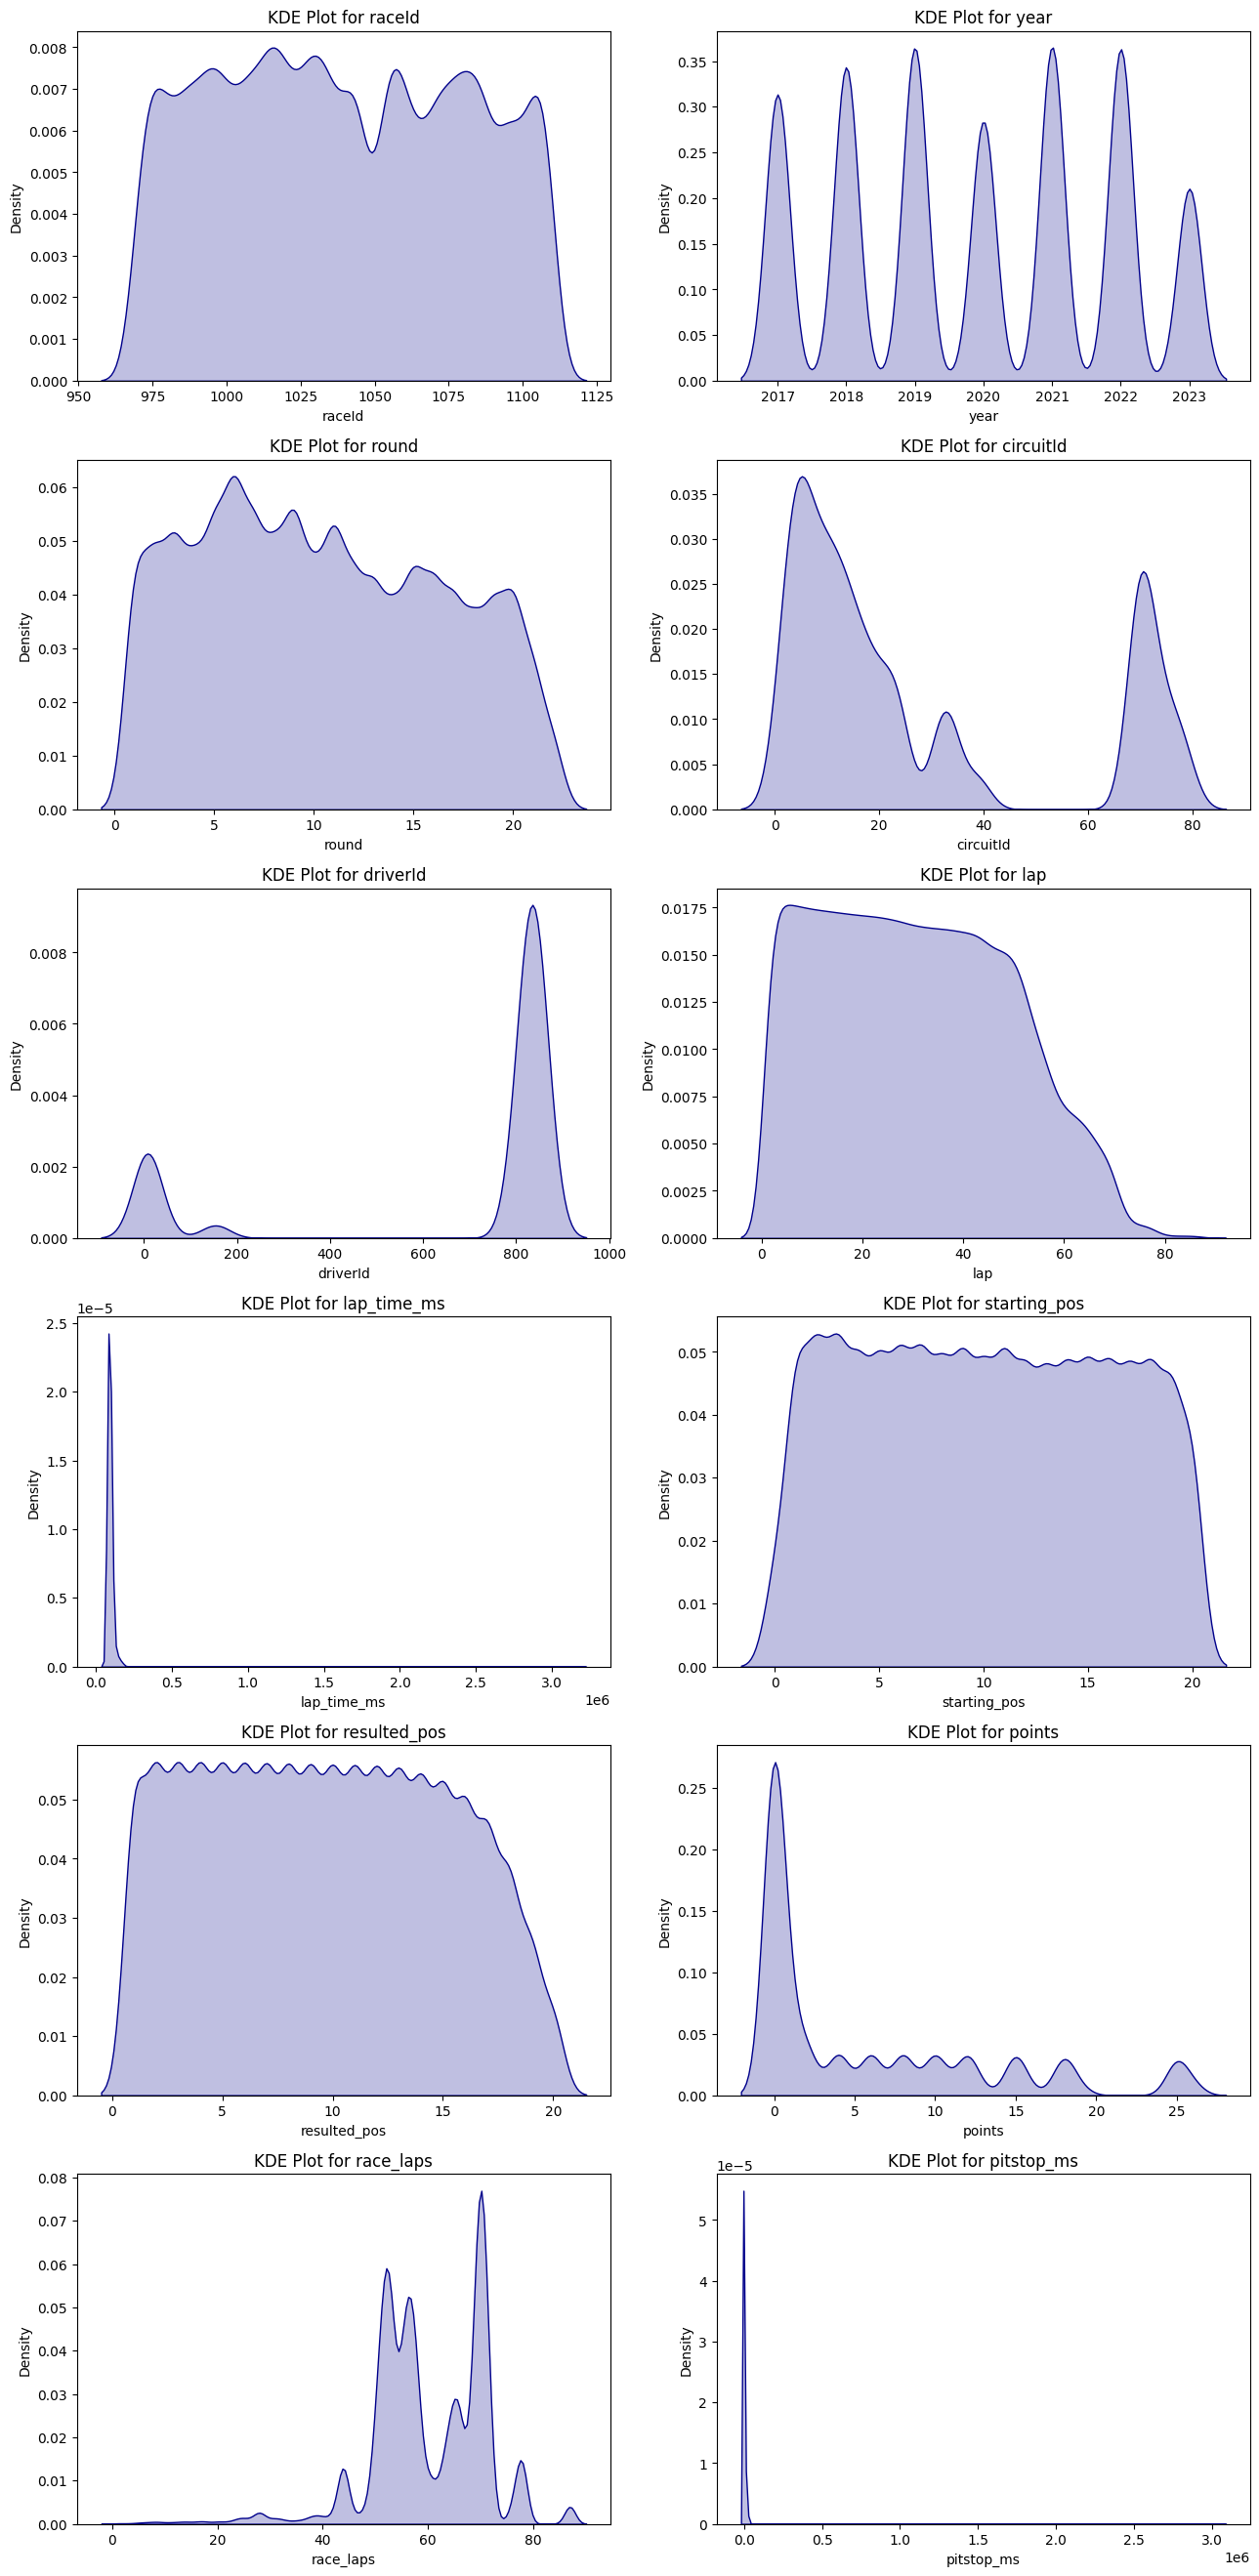

In [42]:
# empty list to store numerical column names
num = []

# Iterate through columns
for column in merged_df.columns:
    # Check if the data type is either int or float
    if merged_df[column].dtype in ['int64', 'float64']:
        # Append the column name to the list
        num.append(column)

# Create a subplot grid based on the number of numerical columns
plt.figure(figsize=(13, 48)) 
for i, column in enumerate(num, start=1):
    plt.subplot(11, 2, i)  # Sizing
    sns.kdeplot(merged_df[column], shade=True, color='darkblue') 
    plt.title(f'KDE Plot for {column}')  # Add title 

plt.tight_layout()  # Adjust layout
plt.show()  # plot


Skewing

In [43]:
numeric_columns.skew()

raceId           0.056964
year             0.021468
round            0.179735
circuitId        0.880114
driverId        -1.393864
lap              0.248333
lap_time_ms     25.688444
starting_pos     0.030270
resulted_pos     0.079512
points           1.242553
race_laps       -0.844107
pitstop_ms      28.371539
dtype: float64

Outlier Removal

In [44]:
Q1 = numeric_columns.quantile(0.25)
Q3 = numeric_columns.quantile(0.75)
IQR = Q3 - Q1
numeric_columns = numeric_columns[~((numeric_columns<(Q1-1.5*IQR)) | (numeric_columns>(Q3+1.5*IQR))).any(axis=1)]
numeric_columns.head()

raceId  year  round  circuitId  driverId  lap  lap_time_ms  \
373365     969  2017      1          1       807    1       105237   
373366     969  2017      1          1       807    2        92223   
373367     969  2017      1          1       807    3        92092   
373368     969  2017      1          1       807    4        91653   
373369     969  2017      1          1       807    5        91580   

        starting_pos  resulted_pos  points  race_laps  pitstop_ms  
373365            11            11     0.0         56         0.0  
373366            11            11     0.0         56         0.0  
373367            11            11     0.0         56         0.0  
373368            11            11     0.0         56         0.0  
373369            11            11     0.0         56         0.0

Skewing After Outlier Removal

In [45]:
numeric_columns.skew()

raceId         -0.004671
year           -0.041778
round           0.189854
circuitId       0.875856
driverId       -0.381789
lap             0.220528
lap_time_ms     0.332202
starting_pos   -0.047924
resulted_pos    0.033309
points          1.362923
race_laps      -0.141246
pitstop_ms      0.000000
dtype: float64

Machine Learning!!!

In [46]:
x = numeric_columns[['raceId','year','round','circuitId','driverId','lap','starting_pos', 'resulted_pos', 'points', 'race_laps', 'pitstop_ms']]
y = numeric_columns['lap_time_ms']

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Create and train a Linear Regression model
model = LinearRegression()
model.fit(x_train, y_train)

LinearRegression()

In [33]:

# Create and train a Linear Regression model
lr = LinearRegression()
lr.fit(x_train, y_train)

# Create and train a Decision Tree Regressor model
dtc = DecisionTreeRegressor()
dtc.fit(x_train, y_train)

# Create and train a Random Forest Regressor model
rfc = RandomForestRegressor()
rfc.fit(x_train, y_train)

# Create and train a k-Nearest Neighbors Regressor model
knn = KNeighborsRegressor()
knn.fit(x_train, y_train)

# Create and train a Support Vector Regressor model
svr = SVR()
svr.fit(x_train, y_train)

# Create and train a Gradient Boosting Regressor model
gbr = GradientBoostingRegressor()
gbr.fit(x_train, y_train)

# Make predictions and evaluate each model
models = [lr, dtc, rfc, knn, svr, gbr]
for model in models:
    predictions = model.predict(x_test)
    mse = mean_squared_error(y_test, predictions)
    print(f"{model.__class__.__name__} - Mean Squared Error: {mse}")

LinearRegression - Mean Squared Error: 90853514.23933513
DecisionTreeRegressor - Mean Squared Error: 21474488.21447747
RandomForestRegressor - Mean Squared Error: 13077040.567599125
KNeighborsRegressor - Mean Squared Error: 27221130.80878236
SVR - Mean Squared Error: 179324245.13951096
GradientBoostingRegressor - Mean Squared Error: 44484874.55847767


In [34]:
# Create and apply MinMaxScaler
scaler = MinMaxScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)

# Create and train a Linear Regression model
lr = LinearRegression()
lr.fit(x_train_scaled, y_train)

# Create and train a Decision Tree Regressor model
dtc = DecisionTreeRegressor()
dtc.fit(x_train_scaled, y_train)

# Create and train a Random Forest Regressor model
rfc = RandomForestRegressor()
rfc.fit(x_train_scaled, y_train)

# Create and train a k-Nearest Neighbors Regressor model
knn = KNeighborsRegressor()
knn.fit(x_train_scaled, y_train)

# Create and train a Support Vector Regressor model
svr = SVR()
svr.fit(x_train_scaled, y_train)

# Create and train a Gradient Boosting Regressor model
gbr = GradientBoostingRegressor()
gbr.fit(x_train_scaled, y_train)

# Make predictions and evaluate each model
models = [lr, dtc, rfc, knn, svr, gbr]
for model in models:
    predictions = model.predict(x_test_scaled)
    mse = mean_squared_error(y_test, predictions)
    print(f"{model.__class__.__name__} - Mean Squared Error: {mse}")
    


LinearRegression - Mean Squared Error: 90853514.23933356
DecisionTreeRegressor - Mean Squared Error: 21370872.89165868
RandomForestRegressor - Mean Squared Error: 13060212.217254506
KNeighborsRegressor - Mean Squared Error: 29309960.95646213
SVR - Mean Squared Error: 162311602.24595827
GradientBoostingRegressor - Mean Squared Error: 44484874.55847769


Min Max Scalar

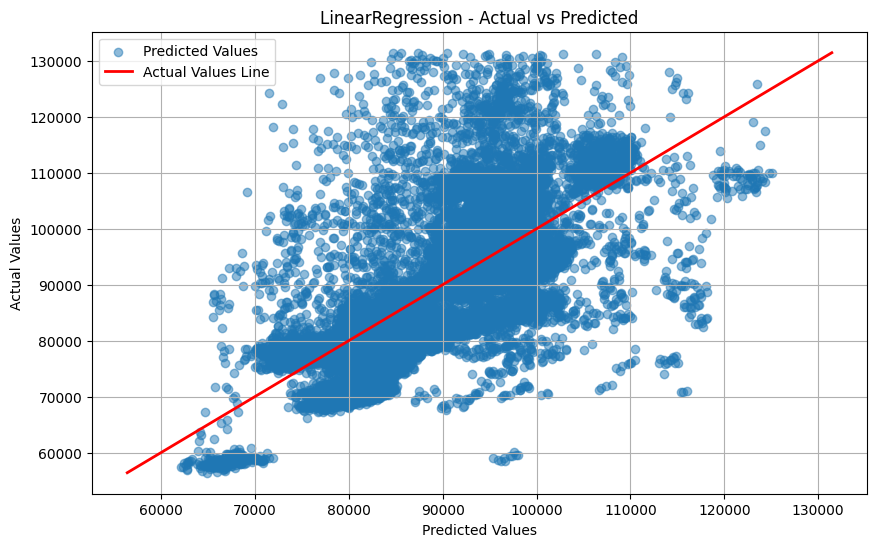

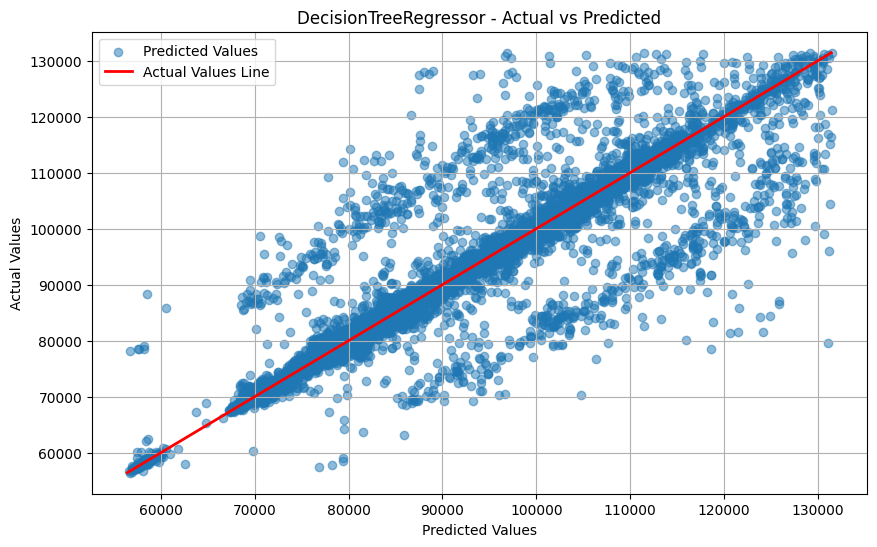

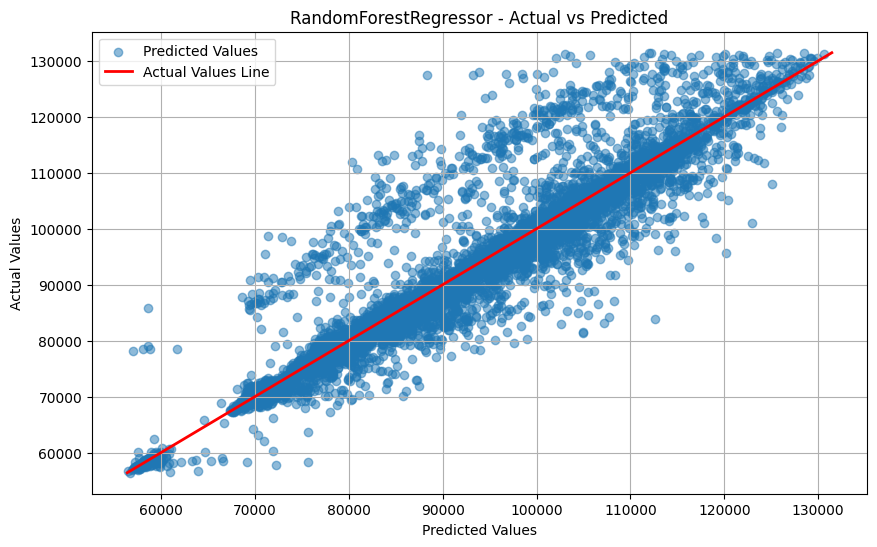

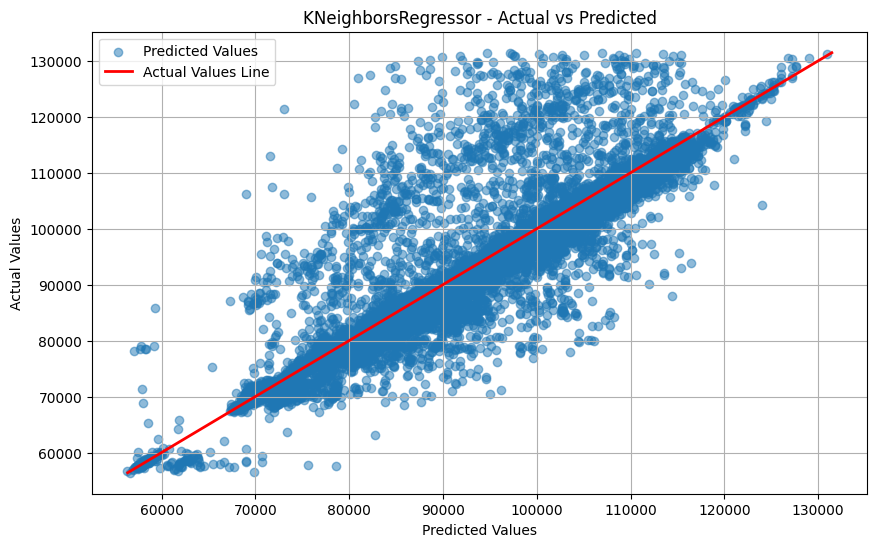

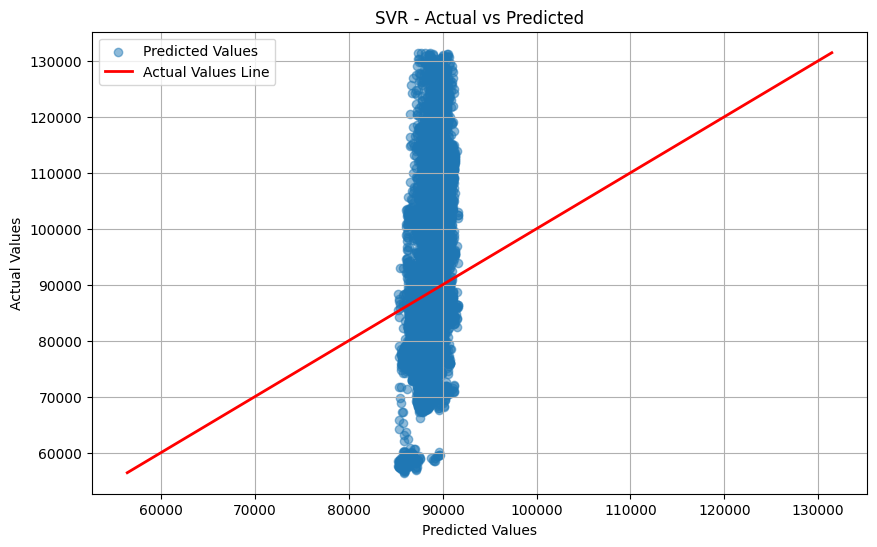

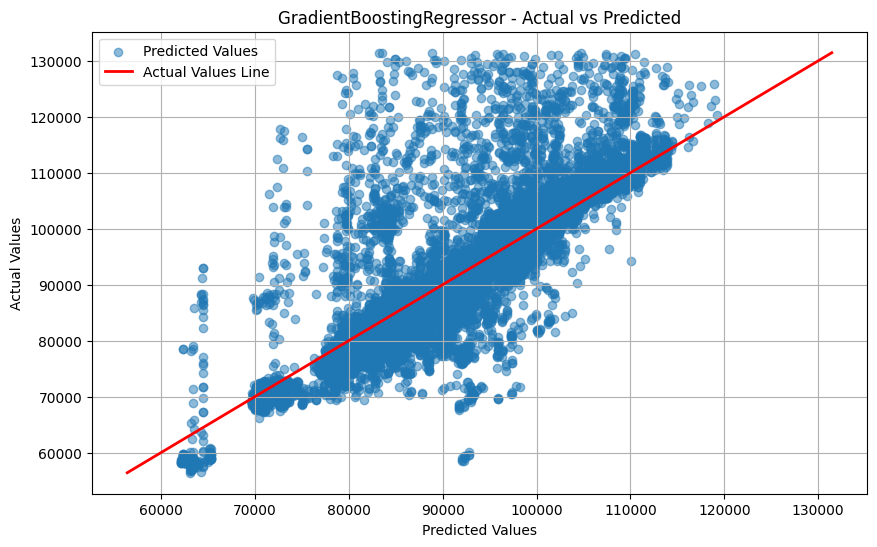

In [35]:
# Function to plot actual vs predicted values
def plot_actual_vs_predicted(y_actual, y_predicted, model_name):
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for predicted values
    plt.scatter(y_predicted, y_actual, alpha=0.5, label='Predicted Values')
    
    # Plot a red line for actual values
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='-', linewidth=2, label='Actual Values Line')
    
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Create and apply MinMaxScaler
scaler_minmax = MinMaxScaler()
x_train_scaled_minmax = scaler_minmax.fit_transform(x_train)
x_test_scaled_minmax = scaler_minmax.transform(x_test)

# Create and train a Linear Regression model with MinMax scaled data
lr_minmax = LinearRegression()
lr_minmax.fit(x_train_scaled_minmax, y_train)

# Create and train a Decision Tree Regressor model with MinMax scaled data
dtc_minmax = DecisionTreeRegressor()
dtc_minmax.fit(x_train_scaled_minmax, y_train)

# Create and train a Random Forest Regressor model with MinMax scaled data
rfc_minmax = RandomForestRegressor()
rfc_minmax.fit(x_train_scaled_minmax, y_train)

# Create and train a k-Nearest Neighbors Regressor model with MinMax scaled data
knn_minmax = KNeighborsRegressor()
knn_minmax.fit(x_train_scaled_minmax, y_train)

# Create and train a Support Vector Regressor model with MinMax scaled data
svr_minmax = SVR()
svr_minmax.fit(x_train_scaled_minmax, y_train)

# Create and train a Gradient Boosting Regressor model with MinMax scaled data
gbr_minmax = GradientBoostingRegressor()
gbr_minmax.fit(x_train_scaled_minmax, y_train)

# Make predictions and evaluate each model with MinMax scaled data
models_minmax = [lr_minmax, dtc_minmax, rfc_minmax, knn_minmax, svr_minmax, gbr_minmax]

# Loop through models
for model in models_minmax:
    model_name_minmax = model.__class__.__name__
    
    # Make predictions on the test set
    predictions_minmax = model.predict(x_test_scaled_minmax)
    
    # Plot actual vs predicted values 
    plot_actual_vs_predicted(y_test, predictions_minmax, model_name_minmax)


Standard Scalar

In [47]:

# Create and apply StandardScaler
scaler_std = StandardScaler()
x_train_std = scaler_std.fit_transform(x_train)
x_test_std = scaler_std.transform(x_test)

# Create and train a Linear Regression model with standardized data
lr_std = LinearRegression()
lr_std.fit(x_train_std, y_train)

# Create and train a Decision Tree Regressor model with standardized data
dtc_std = DecisionTreeRegressor()
dtc_std.fit(x_train_std, y_train)

# Create and train a Random Forest Regressor model with standardized data
rfc_std = RandomForestRegressor()
rfc_std.fit(x_train_std, y_train)

# Create and train a k-Nearest Neighbors Regressor model with standardized data
knn_std = KNeighborsRegressor()
knn_std.fit(x_train_std, y_train)

# Create and train a Support Vector Regressor model with standardized data
svr_std = SVR()
svr_std.fit(x_train_std, y_train)

# Create and train a Gradient Boosting Regressor model with standardized data
gbr_std = GradientBoostingRegressor()
gbr_std.fit(x_train_std, y_train)

# Make predictions and evaluate each model with standardized data
models_std = [lr_std, dtc_std, rfc_std, knn_std, svr_std, gbr_std]
for model in models_std:
    predictions_std = model.predict(x_test_std)
    mse_std = mean_squared_error(y_test, predictions_std)
    print(f"{model.__class__.__name__} with StandardScaler - Mean Squared Error: {mse_std}")


LinearRegression with StandardScaler - Mean Squared Error: 90853514.23933281
DecisionTreeRegressor with StandardScaler - Mean Squared Error: 21067347.586864814
RandomForestRegressor with StandardScaler - Mean Squared Error: 12862233.1396922
KNeighborsRegressor with StandardScaler - Mean Squared Error: 29074364.022051774
SVR with StandardScaler - Mean Squared Error: 148661617.74121395
GradientBoostingRegressor with StandardScaler - Mean Squared Error: 44484563.02178652


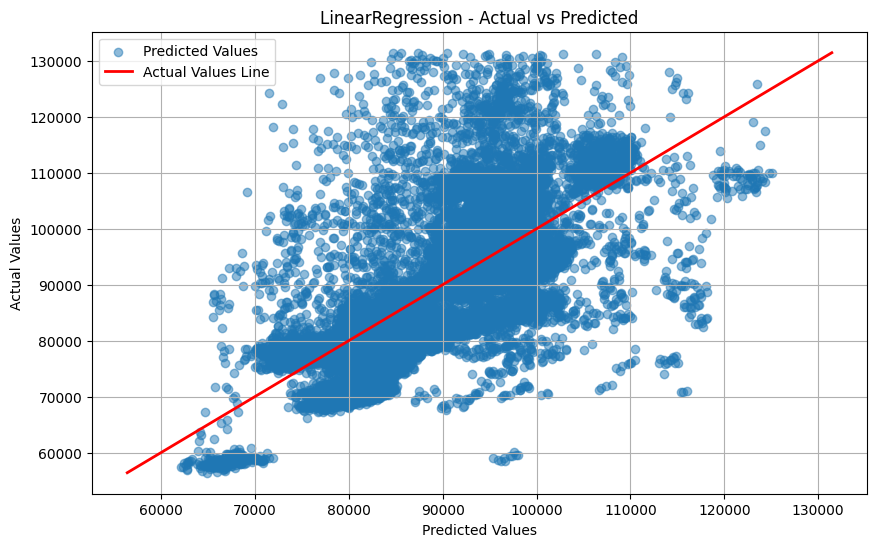

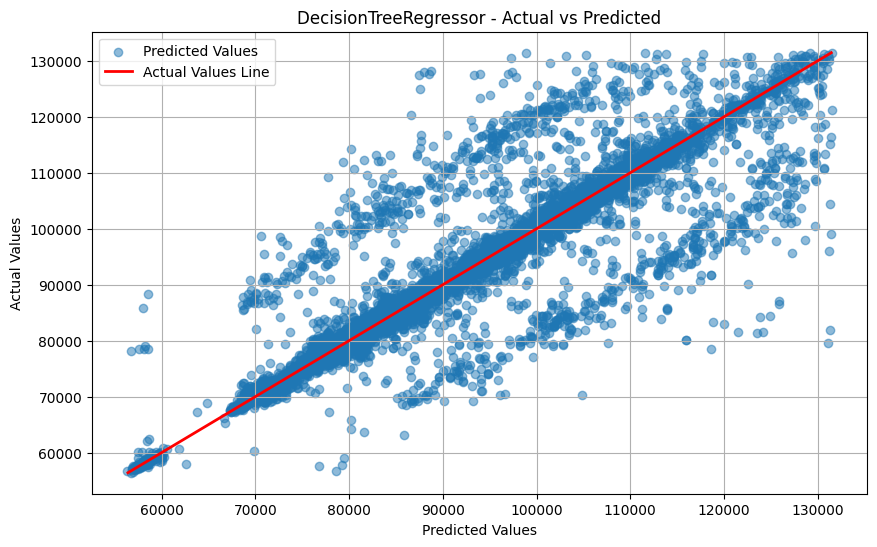

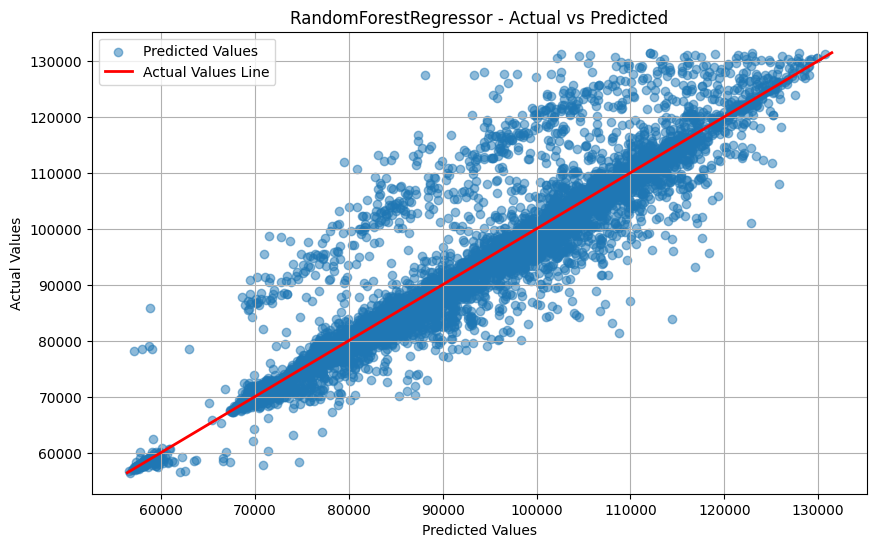

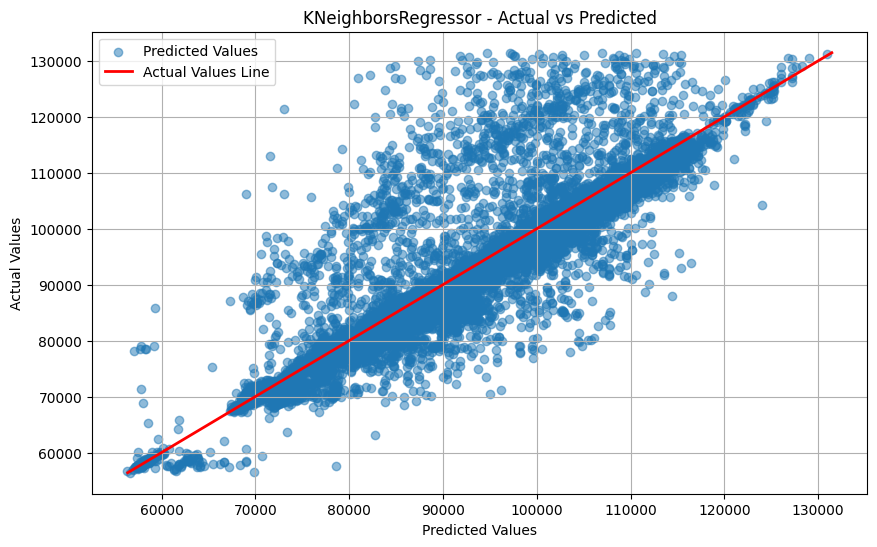

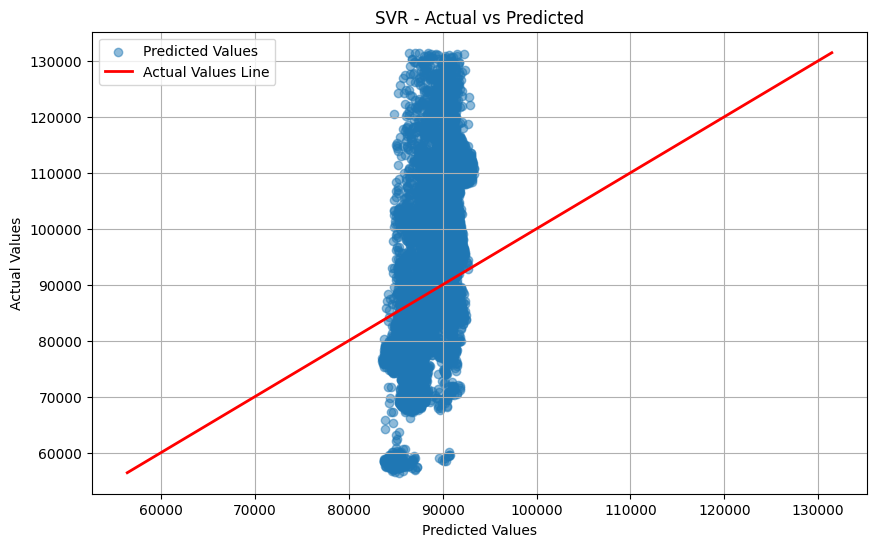

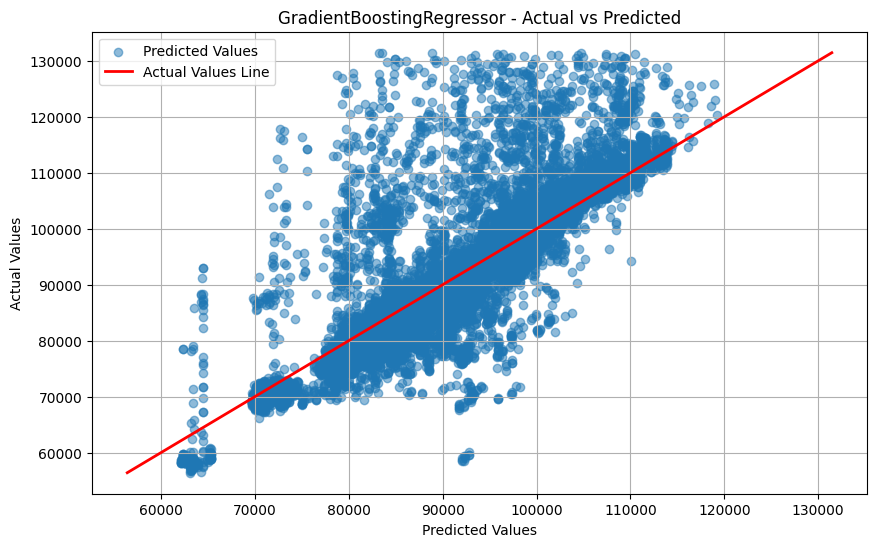

In [48]:
# Function to plot actual vs predicted values 
def plot_actual_vs_predicted_with_line(y_actual, y_predicted, model_name):
    plt.figure(figsize=(10, 6))
    
    # Scatter plot for predicted values
    plt.scatter(y_predicted, y_actual, alpha=0.5, label='Predicted Values')
    
    # Plot a red line for actual values
    plt.plot([min(y_actual), max(y_actual)], [min(y_actual), max(y_actual)], color='red', linestyle='-', linewidth=2, label='Actual Values Line')
    
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    plt.legend()
    plt.grid(True)
    plt.show()

# Loop through models
for model in models_std:
    model_name = model.__class__.__name__
    
    # Make predictions on the test set
    predictions_std = model.predict(x_test_std)
    
    # Plot actual vs predicted values
    plot_actual_vs_predicted_with_line(y_test, predictions_std, model_name)


Robust Scalar

In [49]:
# Create and apply RobustScaler
scaler_robust = RobustScaler()
x_train_robust = scaler_robust.fit_transform(x_train)
x_test_robust = scaler_robust.transform(x_test)

# Create and train models with robustly scaled data
models_robust = {
    "Linear Regression": LinearRegression(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "K-Nearest Neighbors Regressor": KNeighborsRegressor(),
    "Support Vector Regressor": SVR(),
    "Gradient Boosting Regressor": GradientBoostingRegressor()
}

for model_name, model in models_robust.items():
    # Train the model
    model.fit(x_train_robust, y_train)
    
    # Make predictions on the test set
    predictions_robust = model.predict(x_test_robust)
    
    # Calculate MSE and R2
    mse_robust = mean_squared_error(y_test, predictions_robust)
    r2_robust = r2_score(y_test, predictions_robust)
    
    # Print results
    print(f"{model_name} with RobustScaler - MSE: {mse_robust}, R2: {r2_robust}")


Linear Regression with RobustScaler - MSE: 90853514.23933282, R2: 0.4871099437383176
Decision Tree Regressor with RobustScaler - MSE: 21111037.203068074, R2: 0.8808230903396747
Random Forest Regressor with RobustScaler - MSE: 12884126.30786513, R2: 0.9272659916102317
K-Nearest Neighbors Regressor with RobustScaler - MSE: 29130754.597695112, R2: 0.835549846479259
Support Vector Regressor with RobustScaler - MSE: 151649084.34618032, R2: 0.14390425011570573
Gradient Boosting Regressor with RobustScaler - MSE: 44484563.02178651, R2: 0.7488738853742332


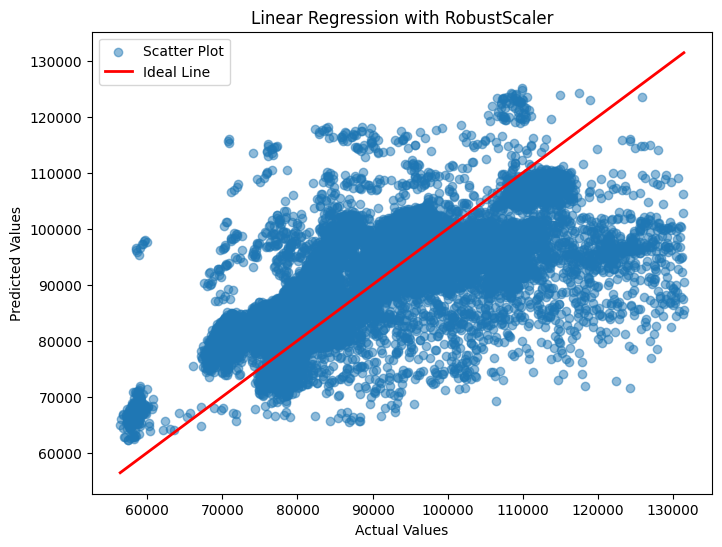

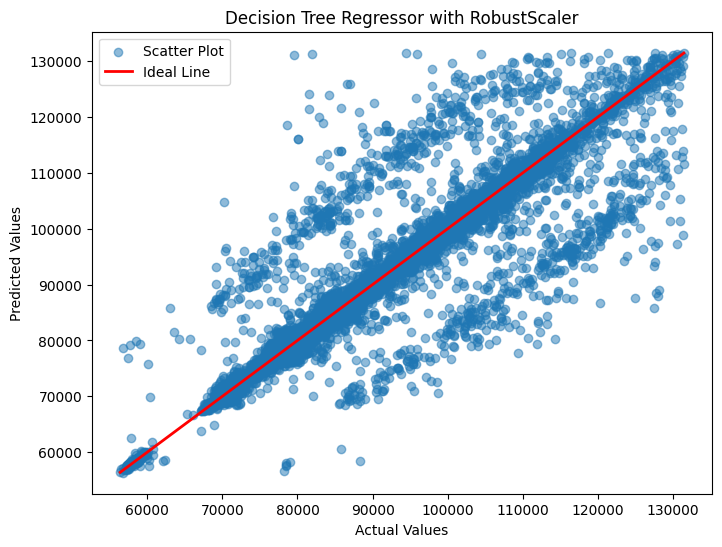

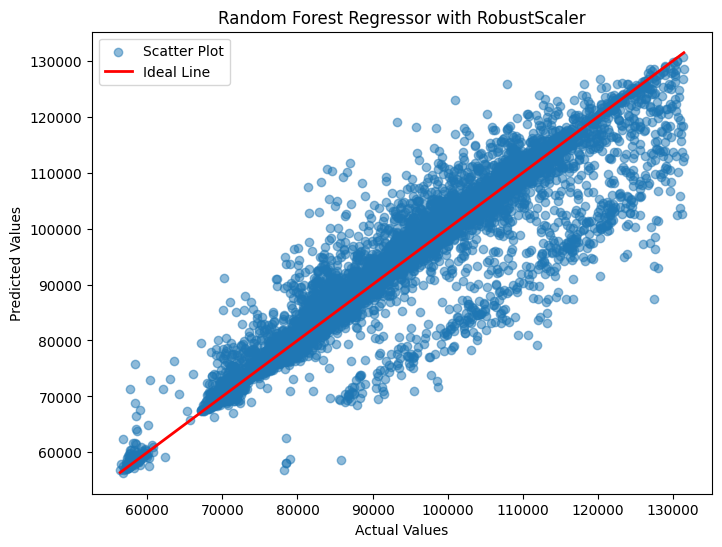

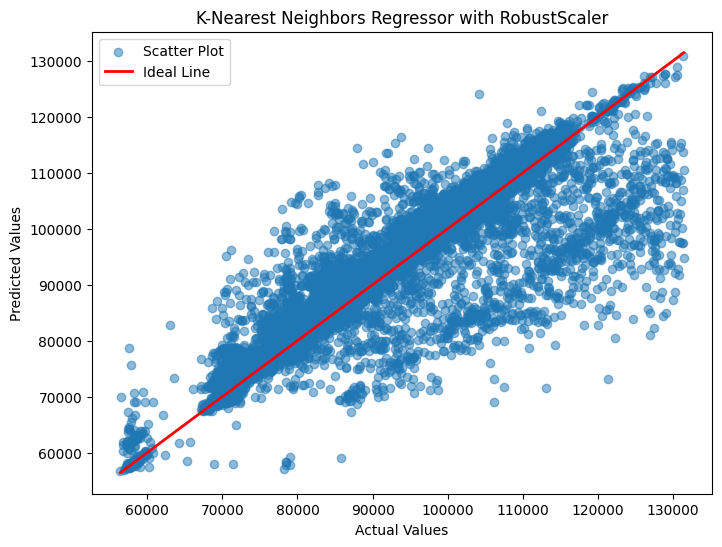

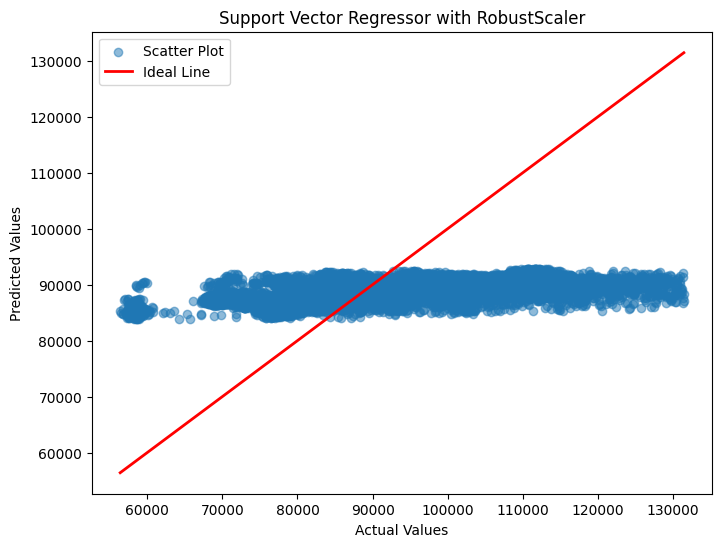

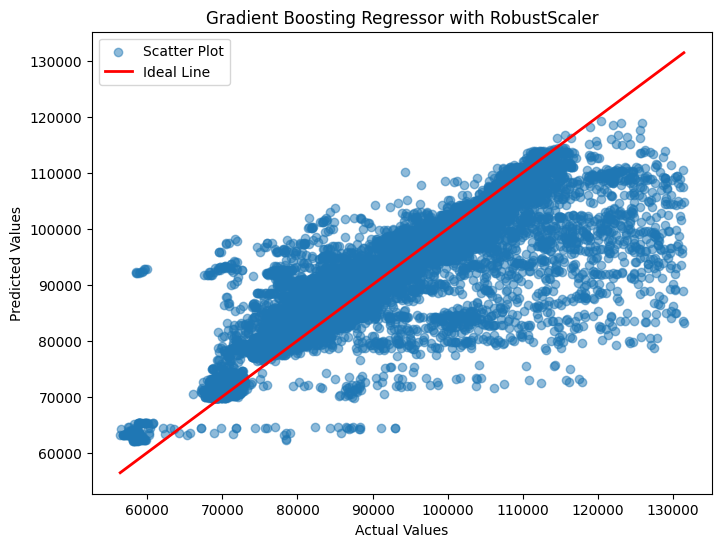

In [50]:
# Define a function to create a scatter plot with a red line
def scatter_plot_with_line(actual, predicted, title):
    plt.figure(figsize=(8, 6))
    
    # Scatter plot for predicted values
    plt.scatter(actual, predicted, alpha=0.5, label='Scatter Plot')
    
    # Plot a red line for actual values
    plt.plot([min(actual), max(actual)], [min(actual), max(actual)], color='red', linestyle='-', linewidth=2, label='Ideal Line')
    
    plt.title(title)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.legend()
    plt.show()

# Loop through models
for model_name, model in models_robust.items():
    # Train the model
    model.fit(x_train_robust, y_train)
    
    # Make predictions on the test set
    predictions_robust = model.predict(x_test_robust)
    
    # Create a scatter plot with a red line for actual values
    scatter_plot_with_line(y_test, predictions_robust, f"{model_name} with RobustScaler")


In [ ]:
# Define the models
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    KNeighborsRegressor(),
    SVR(),
    GradientBoostingRegressor()
]

# Define the scalers
scalers = [RobustScaler(), StandardScaler(), MinMaxScaler()]

# Loop through models
for model in models:
    print(f"Model: {model.__class__.__name__}")
    
    # Loop through scalers
    for scaler in scalers:
        # Scale the features
        x_scaled = scaler.fit_transform(x)
        
        # Set up cross-validation with k folds
        k_folds = 5  
        cv = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        
        # Perform cross-validation and calculate scores
        r2_scores = cross_val_score(model, x_scaled, y, scoring='r2', cv=cv)
        mse_scores = -cross_val_score(model, x_scaled, y, scoring='neg_mean_squared_error', cv=cv)
        mae_scores = -cross_val_score(model, x_scaled, y, scoring='neg_mean_absolute_error', cv=cv)
        
        # Print results
        print(f"\n  Scaler: {scaler.__class__.__name__}")
        print(f"    R2 Score: {r2_scores.mean()}")
        print(f"    Mean Squared Error: {mse_scores.mean()}")
        print(f"    Mean Absolute Error: {mae_scores.mean()}\n")


Model: LinearRegression
  Scaler: RobustScaler
    R2 Score: 0.47606504965355
    Mean Squared Error: 93330578.00601919
    Mean Absolute Error: 7053.199041591336
  Scaler: StandardScaler
    R2 Score: 0.4760650496535499
    Mean Squared Error: 93330578.0060192
    Mean Absolute Error: 7053.199041591302
  Scaler: MinMaxScaler
    R2 Score: 0.47606504965354635
    Mean Squared Error: 93330578.00601985
    Mean Absolute Error: 7053.199041591584
Model: DecisionTreeRegressor
  Scaler: RobustScaler
    R2 Score: 0.8799742499383985
    Mean Squared Error: 21422030.12450623
    Mean Absolute Error: 1584.6435953978907
  Scaler: StandardScaler
    R2 Score: 0.8806783502881267
    Mean Squared Error: 21237712.60240652
    Mean Absolute Error: 1588.1510930009586
  Scaler: MinMaxScaler
    R2 Score: 0.8785944824501982
    Mean Squared Error: 21500638.35480345
    Mean Absolute Error: 1592.1138446788111
Model: RandomForestRegressor
  Scaler: RobustScaler
    R2 Score: 0.9247039971510178
    Mean Sq

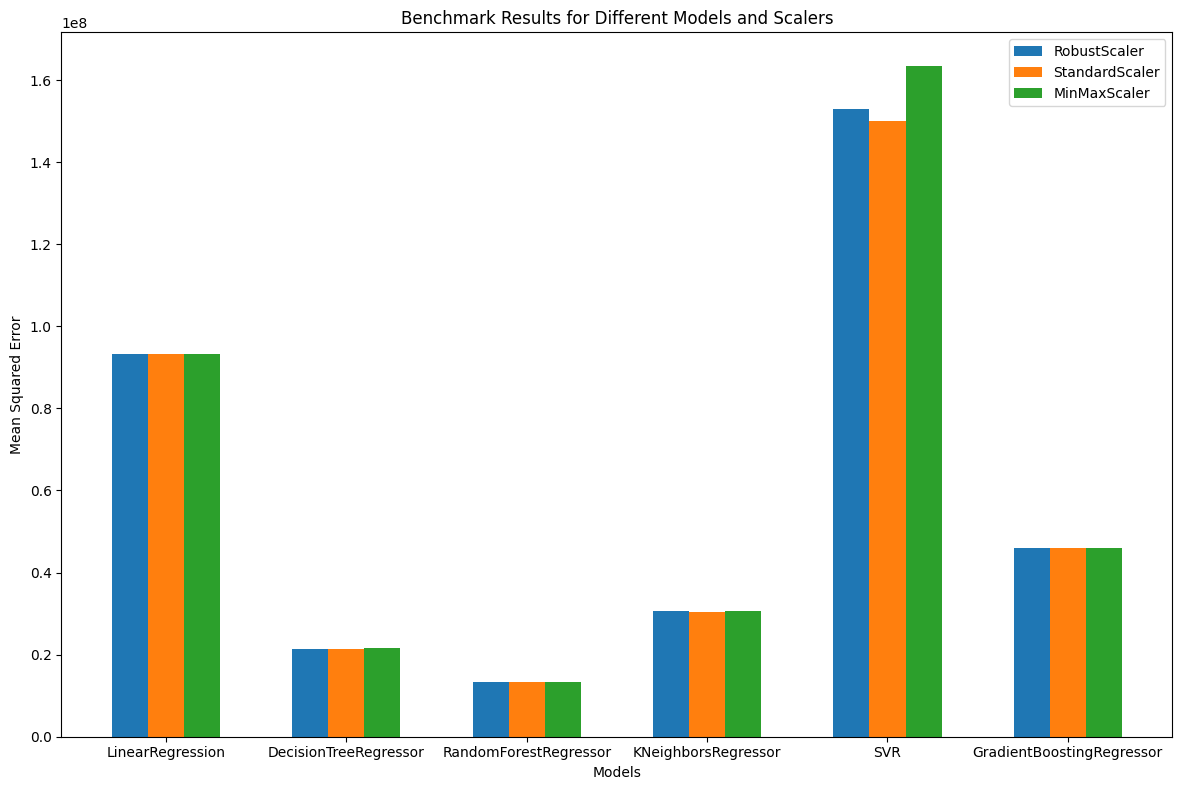

In [ ]:



# Store results in a dictionary
results = {}

# Loop through models
for model in models:
    model_name = model.__class__.__name__
    
    # Loop through scalers
    for scaler in scalers:
        scaler_name = scaler.__class__.__name__
        
        # Scale the features
        x_scaled = scaler.fit_transform(x)
        
        # Set up cross-validation with k folds
        k_folds = 5  
        cv = KFold(n_splits=k_folds, shuffle=True, random_state=42)
        
        # Perform cross-validation and calculate mean squared error
        mse_scores = cross_val_score(model, x_scaled, y, scoring='neg_mean_squared_error', cv=cv)
        mse_mean = -mse_scores.mean()
        
        # Store the results in the dictionary
        results[(model_name, scaler_name)] = mse_mean

# Extract data for plotting
model_names = [model.__class__.__name__ for model in models]
scaler_names = [scaler.__class__.__name__ for scaler in scalers]
bar_width = 0.2
bar_positions = np.arange(len(model_names))

# Plot the bar chart
plt.figure(figsize=(12, 8))

for i, scaler_name in enumerate(scaler_names):
    mse_values = [results[(model_name, scaler_name)] for model_name in model_names]
    plt.bar(bar_positions + i * bar_width, mse_values, bar_width, label=scaler_name)

plt.xlabel('Models')
plt.ylabel('Mean Squared Error')
plt.title('Benchmark Results for Different Models and Scalers')
plt.xticks(bar_positions + bar_width * (len(scalers) - 1) / 2, model_names)
plt.legend()

plt.tight_layout()
plt.show()
